In [104]:
import os
import subprocess
import time
import re
import random

import matplotlib.pyplot as plt

In [105]:
# Environment variables
topology_file="untitled.imn"
bandwidth="1000000000"
scenario_id="i2008"
delay="1000"
fluxes="1"

# Define the topology
links = [
    "switch1:pc1",
    "switch1:pc3",
    "switch1:pc2",
    "switch1:pc4",
]

In [106]:
def run_iperf_and_capture_data(client_pc, server_ip, scenario_id, size="100M", parallel="1", interval="1", duration=10):

    client_pc_str = str(client_pc)
    server_ip_str = str(server_ip)
    scenario_id_str = str(scenario_id)
    size_str = str(size)
    parallel_str = str(parallel)
    interval_str = str(interval)
    duration_str = str(duration)

    cmd = [
        "sudo", "himage", f"{client_pc_str}@{scenario_id_str}",
        "iperf", "-c", server_ip_str, "-n", size_str, "-P", parallel_str, "-i", interval_str, "-t", duration_str
    ]

    print(f"Running TCP test from {client_pc_str} to {server_ip_str} for {duration_str} seconds...")

    process = subprocess.run(cmd, capture_output=True, text=True)
    output = process.stdout

    # Regex fixa para MBytes (não importa a unidade que aparece, pois vamos ajustar depois)
    pattern = re.compile(
        r"\[\s*\d+\]\s+([\d.]+)-([\d.]+)\s+sec\s+([\d.]+)\s+MBytes\s+([\d.]+)\s+Mbits/sec"
    )
    results = pattern.findall(output)

    if results:
        time_points = []
        transfers = []
        bandwidths = []

        # Decide o fator de correção com base no sufixo do parâmetro 'size'
        if size_str.upper().endswith("K"):
            divisor = 1024
        elif size_str.upper().endswith("M"):
            divisor = 1
        elif size_str.upper().endswith("G"):
            divisor = 1 / 1024
        else:
            print(f"Warning: unidade não reconhecida no parâmetro 'size': {size_str}")
            divisor = 1  # default (assume MBytes)

        for start, end, transfer, bandwidth in results:
            time_points.append(float(end))
            transfers.append(float(transfer) / divisor)
            bandwidths.append(float(bandwidth) / divisor)

        return time_points, transfers, bandwidths
    else:
        print("Nenhum resultado encontrado na saída do iperf.")
        print("Saída bruta:")
        print(output)
        return [], [], []


In [107]:
# link configuration
def configure_links(bandwidth, delay, loss, scenario_id):
    for link in links:
        subprocess.run(
            ["sudo", "vlink", "-bw", bandwidth, "-dly", delay, f"{link}@{scenario_id}"],
            stdout=subprocess.DEVNULL
        )

    time.sleep(1)

    # Check status
    for link in links:
        subprocess.run(
            ["sudo", "vlink", "-s", f"{link}@{scenario_id}"]
        )

In [108]:
# Configure computers...
def configure_computers(scenario_id):
    # Start iperf servers
    subprocess.Popen(
        ["sudo", "himage", f"pc2@{scenario_id}", "iperf", "-s"],
        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
    )
    subprocess.Popen(
        ["sudo", "himage", f"pc4@{scenario_id}", "iperf", "-s"],
        stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL
    )

In [109]:
def starts_simulation(scenario_id):
    result = subprocess.run(
        ["sudo", "imunes", "-d", "-b", "-e", scenario_id, topology_file],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    print("STDOUT:\n", result.stdout)
    print("STDERR:\n", result.stderr)
    
def stop_simulation(scenario_id):
    subprocess.run(
        ["sudo", "imunes", "-b", "-e", scenario_id], 
        stdout=subprocess.DEVNULL
    )
    

In [110]:
def run_imunes_simulation(
    topology_file="untitled.imn",
    bandwidth="1000000000",
    scenario_id="i2002",
    delay="10000",
    fluxes="1"
):
    # Start simulation
    print("=" * 56)
    print(f"Starting IMUNES simulation with scenario ID: {scenario_id}")
    starts_simulation(scenario_id)
    time.sleep(3)

    # Configure links
    print("=" * 56)
    print("Simulation started, configuring links...")
    configure_links(bandwidth, delay, 0, scenario_id)
    time.sleep(1)

    # Configure computers
    print("=" * 56)
    print("Configuring computers...")
    configure_computers(scenario_id)
    time.sleep(1)

    # Run iperf tests
    print("=" * 56)
    time_pts, transfers, bandwidths = run_iperf_and_capture_data(client_pc="pc3",server_ip="10.0.0.20",scenario_id=scenario_id,)

    # Stop simulation
    print("=" * 56)
    print(f"Stopping IMUNES simulation with scenario ID: {scenario_id}")
    stop_simulation(scenario_id)
    print("Simulation stopped")

    return time_pts, transfers, bandwidths



In [111]:
def generate_bandwidth_sequence(length=30):
    states = [50, 0, 10]
    probabilities = [0.1, 0.2, 0.7]
    return random.choices(states, weights=probabilities, k=length)


In [112]:
def mbps_to_bytes_per_sec(mbps):
    return int((mbps * 1_000_000) / 8)

def run_markov_iperf(client_pc, server_ip, scenario_id, interval=1, duration_per_state=8, num_transitions=20):
    # Estados possíveis e suas probabilidades
    states = ["HIGH", "ZERO", "LOW"]
    probabilities = [0.1, 0.2, 0.7]

    # Mapear estados para velocidades
    bandwidth_map = {
        "HIGH": 50,   # 50 Mbps
        "ZERO": 0,    # 0 Mbps
        "LOW": 10     # 10 Mbps
    }

    time_points = []
    transfers = []
    bandwidths = []

    current_time = 0

    for i in range(num_transitions):
        state = random.choices(states, probabilities)[0]
        bandwidth = bandwidth_map[state]

        print(f"\nTransição {i+1}/{num_transitions} - Estado: {state}, Bandwidth: {bandwidth} Mbps")

        if bandwidth > 0:
            bw_str = f"{bandwidth}M"
            delay_str = "1ms"   # pode ajustar conforme necessário
            loss_str = "0%"     # não está sendo usado no seu configure_links atual
            configure_links(bw_str, delay_str, loss_str, scenario_id)

        # Ajustar o size com base no valor da largura de banda
        if bandwidth == 50:
            size = "50M"
        elif bandwidth == 10:
            size = "10M"
        elif bandwidth == 0:
            size = "1K" 

        t_pts, trans, bwds = run_iperf_and_capture_data(
            client_pc=client_pc,
            server_ip=server_ip,
            scenario_id=scenario_id,
            duration=duration_per_state,
            interval=interval,
            size=size
        )

        print("Tempo (s):", t_pts)
        print("Transferências (MB):", trans)
        print("Bandwidths (Mbps):", bwds)

        t_pts = [current_time + t for t in t_pts]
        current_time += duration_per_state

        time_points.extend(t_pts)
        transfers.extend(trans)
        bandwidths.extend(bwds)

        time.sleep(1)

    return time_points, transfers, bandwidths


In [113]:
def run_imunes_simulation(
    topology_file="untitled.imn",
    bandwidth="10000000",
    scenario_id="i2002",
    delay="10000",
    fluxes="1"
):
    # Start simulation
    print("=" * 56)
    print(f"Starting IMUNES simulation with scenario ID: {scenario_id}")
    starts_simulation(scenario_id)
    time.sleep(3)

    # Configure links
    print("=" * 56)
    print("Simulation started, configuring links...")
    configure_links(bandwidth, delay, 0, scenario_id)
    time.sleep(1)

    # Configure computers
    print("=" * 56)
    print("Configuring computers...")
    configure_computers(scenario_id)
    time.sleep(1)

    # Run iperf tests using Markov-based traffic generation
    print("=" * 56)
    print("Running Markov-based iperf traffic generation...")
    time_pts, transfers, bandwidths = run_markov_iperf(
        client_pc="pc3",
        server_ip="10.0.0.20",
        scenario_id=scenario_id,
        interval=1,
        duration_per_state=5,
        num_transitions=8

    )

    # Stop simulation
    print("=" * 56)
    print(f"Stopping IMUNES simulation with scenario ID: {scenario_id}")
    stop_simulation(scenario_id)
    print("Simulation stopped")

    return time_pts, transfers, bandwidths


In [114]:

def plot_iperf_graph(time_points, transfers, bandwidths, title="Bandwidth Over Time"):
    if not time_points or not bandwidths:
        print("Vetores vazios, nada a plotar.")
        return

    plt.figure(figsize=(16, 9))
    plt.plot(time_points, bandwidths, marker='o', linestyle='-', color='blue')
    plt.plot(time_points, transfers, marker='x', linestyle='--', color='red')
    plt.title(title)
    plt.xlabel("Tempo (s)")
    plt.ylabel("Largura de Banda (Mbps)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Starting IMUNES simulation with scenario ID: i2008
STDOUT:
 Using experiment ID 'i2008'.
Preparing for initialization...
Instantiating VIRTUALIZED nodes...

                                                
> 0/4 
                                                
> 1/4 
                                                
> 2/4 
                                                
> 3/4 
                                                
> 4/4 
Waiting for 4 VIRTUALIZED node(s) to start...

                                                
> 0/4 
                                                
> 1/4 
                                                
> 2/4 
                                                
> 2/4 
                                                
> 3/4 
                                                
> 4/4 
                                                
> 4/4 
Setting up namespaces for all nodes...

                                                
> 0/5 
                            

Simulation stopped


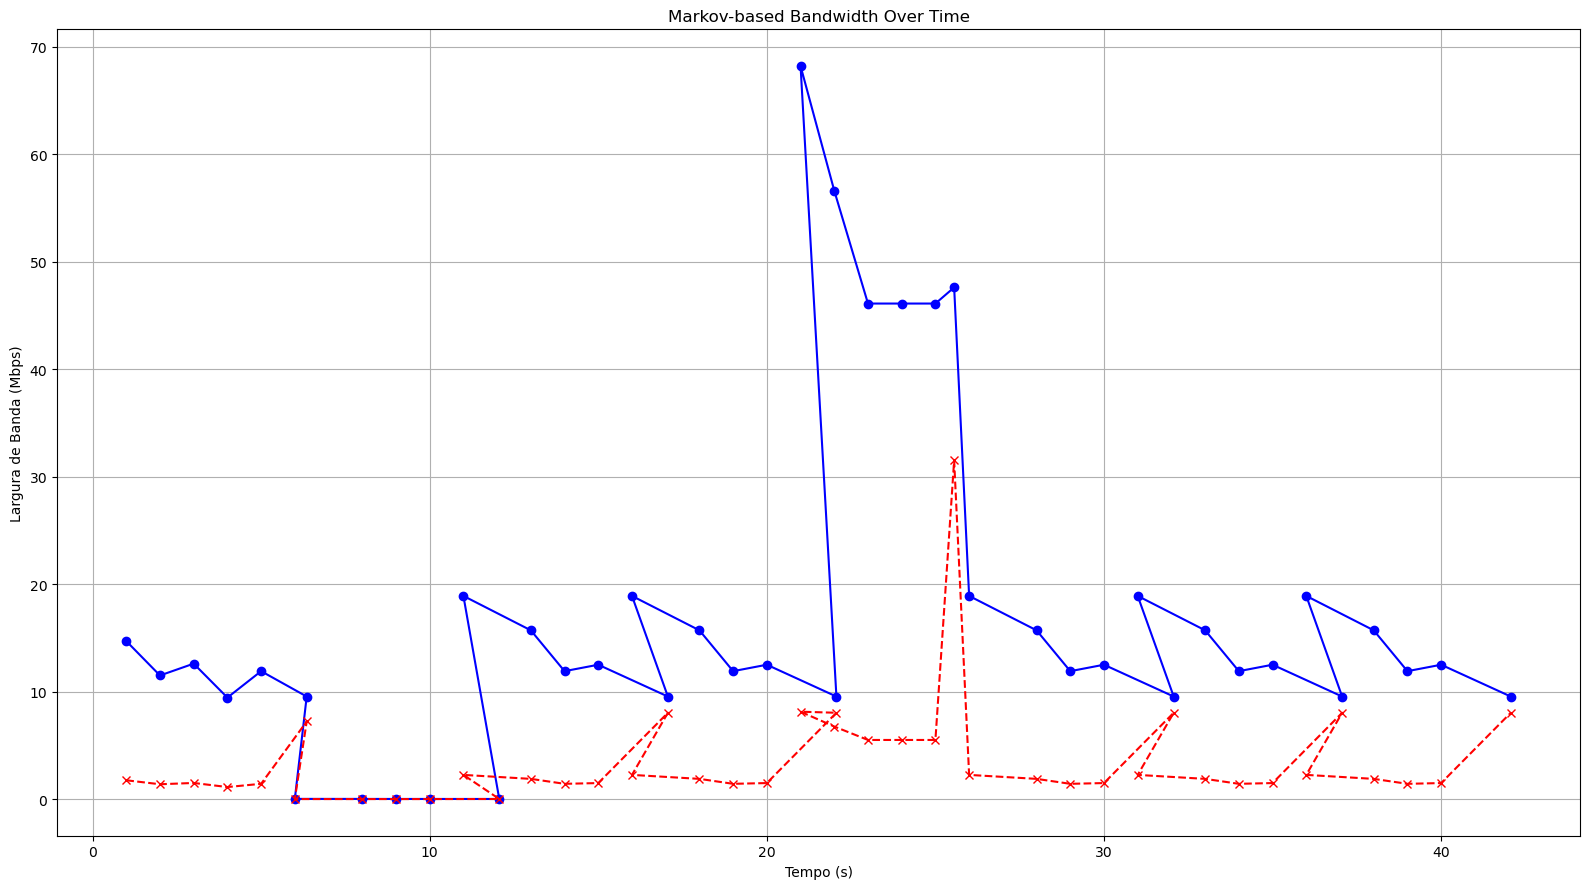

In [115]:
time_pts, transfers, bandwidths = run_imunes_simulation(
    topology_file=topology_file,
    bandwidth=bandwidth,
    scenario_id=scenario_id,
    delay=delay,
    fluxes=fluxes
)

        # Plotar gráfico
plot_iperf_graph(
        time_points=time_pts,
        transfers=transfers,
        bandwidths=bandwidths,
        title="Markov-based Bandwidth Over Time"
)

